## Simple Graph w/ LLM

Now we want to actually leverage an llm in our graph. How can we do that? 

The steps are actually very similar, with just some small tweaks:
- in the node we will now call an llm (we'll see how)
- we will be using the `MessagesState` class provided by LangGraph as state (so we skip state definition)

Let's expand on both concepts:

### State

We said that we can create LangGraph states by using `TypedDict`, and that still holds on when we use llm's. But, LangGraph has actually built pre-defined state for us to use in this sort of applications: so why re-invent the wheel?

More specifically, we have the [`MessagesState`](https://docs.langchain.com/oss/python/langgraph/graph-api#messagesstate) class: "Since having a list of messages in your state is so common, there exists a prebuilt state called MessagesState which makes it easy to use messages." 

At its core, `MessagesState` is just a `TypedDict` with a list of strings - the messages.

Since we will be using that, we can skip state creation and afterwards we will just instantiate `StateGraph(MessagesState)` when building the graph. 

>If we want a more complex state other than just messages, we can expand the pre-built class with other fields. We will do that later on.

### Nodes

Now our nodes: actually we just need a node that calls our llm with the given message. 

How can we build that? 

In [1]:
from dotenv import load_dotenv
load_dotenv()  # load api keys

True

In [2]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

def call_llm(state: MessagesState) -> MessagesState:
    """A simple node that calls an llm with the messages in state."""

    result = llm.invoke(state['messages'])  # invoke the llm on our state - the result is an AIMessage

    return {"messages" : [result]}  # wrap it in a list for updates

This simple implementation contains precious information. 

We can see how we are invoking our llm on the state's `messages`, and using the result to update our graph state.

**(!) Returning a Dictionary of Updates:** this is a crucial concept in LangGraph, and sometimes counterintuitive. **Nodes do not return a new state**, they must **only return state updates**. This is how LangGraph processes nodes outputs.

In this case, we are updating our `'messages'` list in state with the last message produced by our AI model. Notice how we are wrapping it in a list: this is because the `MessagesState`'s *reducer* (see later on) is made to work with lists.

### Edges (building the graph)

We have all the core pieces, we just need to link them together:

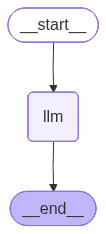

In [3]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

builder = StateGraph(MessagesState)
builder.add_node("llm", call_llm)
builder.add_edge(START, "llm")
builder.add_edge("llm", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

### Invoke the Graph

In [4]:
from langchain_core.messages import HumanMessage

init_message= HumanMessage(content="Hello, who are you?")

response = graph.invoke({"messages" : [init_message]})   # notice we need to wrap it in a list

In [5]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

Hello, who are you?
================================== Ai Message ==================================

Hello! I'm an AI language model developed by OpenAI. I'm here to assist you with a variety of questions and tasks, like providing information, answering queries, and giving recommendations. How can I help you today?


## Agent Graph

Now we will implement a graph that invokes an llm with tools: an agentic system.

The structure of our graph will be the following:

<img src="./images/better_agent_w_tools.png" alt="Descrizione immagine">

### State

Again, we will actually skip state creation (don't worry: it will come back in the next notebook), since we will be using the `create_agent()` built-in function from `langchain.agents`. This automatically defaults to the `AgentState` class (which is an upgrade of `MessagesState`).

More on this class later on - right now let's just focus on how we can create an agent: 

### `create_agent()`

We already said that we just want *a simple graph that invokes an agent, and loops with some tools*. So, the immediate thing that comes to mind would be to create an 'agent' node, a 'tools' node, and connect them with edges. 

We could do that, but *LangGraph kindly does it for us already* :) . All of this is implemented in one of LangGraph core functions, the [**`create_agent()` function**](https://reference.langchain.com/python/langchain/agents/?h=agent#langchain.agents.create_agent).

>For more info on how you would build this from basic langgraph principles, see [this link](https://docs.langchain.com/oss/python/langgraph/workflows-agents#agents). `create_agent()` basically implements:
>-  an '`llm_call`' node where we invoke the agent, 
>- a '`tool`' node where we check what tools the llm called - and then execute the calls
>- and a '`should_continue`' conditional edge that checks wether the llm made tool calls or not. 

Let's create our agent!

In [6]:
prompt="""
You are a helpful assistant that can use tools to answer questions.
"""

In [7]:
from langchain.agents import create_agent
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o")  # choose a model

agent_v0 = create_agent(  # version 0
    model=model,
    tools=[],  # empty list for now
    system_prompt=prompt,
)

The `tools` field is now an empty list, so the agent defaults to a simple llm without tools.

Let's give it some tools.

### Defining Tools

Defining tools is quite simple: we just need to write a function and decorate it with the `@tool` decorator. 

Let's create an example tool that just elevates a number to the power of another number. 

In [8]:
from langchain.tools import tool

@tool
def power(base: int, exponent: int) -> int:
    """
    Use this to elevate a number to the power of another number.
    Args:
        base: int - the base
        exponent: int - the exponent
    """
    return base**exponent

Inside this simple tool we have some precious information for working with LangGraph. Let's dissect what we wrote: 

1. **Parameters:** the parameters of the tool are obviously our base and our exponent. The key concept is that these parameters **will be filled by the agent**. As a matter of fact, the agent has the ability to call any python function we decorate with `@tool`. 

    It calls these tools as we would: after we define the above function, if **we** wanted to use it in code we would do something like: 
    ```python
    result = power(base=3, exponent=4)  # compute 3**4
    ```
    And this is exactly what the agent will do: it will call the function, filling out the parameters.

2. **Documentation:** notice we gave our simple tool some docstring to describe what it does and how to use it. This was not made for good practices, **it is actually required in tools definitions**. These docstrings are *read by the agent* and specify to it how it should use the given functions, and what parameters it should pass as input. If we do not write any docstring, the code would error!

3. On the same page, **Type Hints** are very useful for agents, and we should always specify those as well.
    

#### Give Tools to the Agent

Now that we created our tool, we can actually create the new version of our agent with such tools: 

In [10]:
agent_v1 = create_agent(  # version 1
    model=model,
    tools=[power],  # add the tool here
    system_prompt=prompt,
)

### Invocation

We can actually directly invoke an agent created with `create_agent()` without building a graph with nodes and edges. 

This is because the function creates a compiled graph already. So for example we can already do:

In [11]:
result = agent_v1.invoke({"messages" : [HumanMessage(content="What is 3 to the power of 4?")]})

In [12]:
for message in result['messages']:
    message.pretty_print()

================================ Human Message =================================

What is 3 to the power of 4?
================================== Ai Message ==================================
Tool Calls:
  power (call_PIWX4VQnzq1ZS1L0rLb3w46j)
 Call ID: call_PIWX4VQnzq1ZS1L0rLb3w46j
  Args:
    base: 3
    exponent: 4
================================= Tool Message =================================
Name: power

81
================================== Ai Message ==================================

3 to the power of 4 is 81.
